# E-Commerce Sales Analysis

In [2]:
# Finds the project root reliably and builds the SQLite DB if missing.
import sys, subprocess, sqlite3
from pathlib import Path
import pandas as pd

# Locate repo root (where src/sql/build_db.py lives)
cwd = Path.cwd().resolve()
candidates = [cwd, cwd.parent, cwd.parent.parent]
root = next((p for p in candidates if (p / "src/sql/build_db.py").exists()), cwd)

db_path = root / "data" / "ecommerce.db"
builder = root / "src" / "sql" / "build_db.py"

if not db_path.exists():
    print("DB missing → building…")
    subprocess.run([sys.executable, str(builder)], check=True)

conn = sqlite3.connect(str(db_path))
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)

,name
0,customers
1,products
2,orders


In [3]:
orders = pd.read_sql("""
SELECT o.*, p.category, p.base_price, c.segment, c.country
FROM orders o
JOIN products p USING(product_id)
JOIN customers c USING(customer_id)
""", conn, parse_dates=["order_date"])

orders["order_month"] = orders["order_date"].dt.to_period("M").dt.to_timestamp()
orders["revenue"] = (orders["base_price"] * (1 - orders["discount"])) * orders["quantity"]
orders.head()

,order_id,order_date,customer_id,product_id,quantity,discount,shipping,status,category,base_price,segment,country,order_month,revenue
0,856,2024-01-21,1214,1,3,0.04,Express,Completed,Electronics,317.13,Consumer,US,2024-01-01,913.3344
1,1097,2024-06-22,3813,1,2,0.07,Standard,Completed,Electronics,317.13,Corporate,FR,2024-06-01,589.8618
2,1513,2023-06-15,609,1,1,0.00,Standard,Completed,Electronics,317.13,Corporate,UK,2023-06-01,317.1300
3,2768,2024-03-16,4464,1,3,0.02,Two-Day,Completed,Electronics,317.13,Enterprise,FR,2024-03-01,932.3622
4,3366,2023-03-04,1518,1,1,0.15,Standard,Completed,Electronics,317.13,Enterprise,FR,2023-03-01,269.5605


In [4]:
kpis = orders.groupby("order_month").agg(
    revenue=("revenue","sum"),
    orders=("order_id","count"),
    aov=("revenue","mean"),
    completion_rate=("status", lambda s: (s=="Completed").mean())
).reset_index()

outdir = (root / "reports" / "figures")
outdir.mkdir(parents=True, exist_ok=True)
kpis.to_csv(outdir / "monthly_kpis.csv", index=False)
kpis.head()

,order_month,revenue,orders,aov,completion_rate
0,2023-01-01,1.357014e+06,2816,481.894345,0.917614
1,2023-02-01,1.219325e+06,2502,487.340184,0.930456
2,2023-03-01,1.410836e+06,2862,492.954550,0.924179
3,2023-04-01,1.324442e+06,2691,492.174516,0.920476
4,2023-05-01,1.419929e+06,2889,491.495016,0.923157


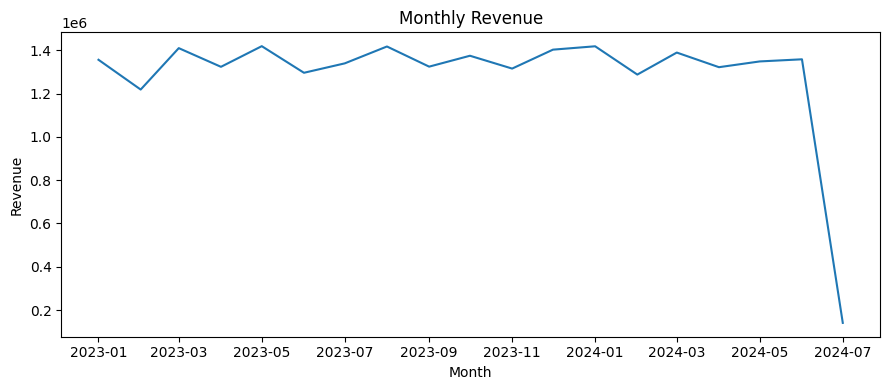

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(kpis["order_month"], kpis["revenue"])
plt.title("Monthly Revenue"); plt.xlabel("Month"); plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(outdir / "monthly_revenue.png", dpi=140)
plt.show()

conn.close()

In [6]:
import os, pathlib
print("CWD:", pathlib.Path.cwd())
print("Exists builder?", (pathlib.Path.cwd().parent / "src/sql/build_db.py").exists())

CWD: /Users/sultanmuhammad/Documents/GitHub Projects/E-Commerce-Sales-Analysis-main/notebooks
Exists builder? True
